In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
from datetime import datetime, timedelta
import operator
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
%matplotlib notebook

In [2]:
# Create a dataframe with rainfall data, and roll up hourly rainfall into a series.
# Similar to previous notebooks

rain_df = pd.read_csv('data/ohare_hourly_20160929.csv')
rain_df['datetime'] = pd.to_datetime(rain_df['datetime'])
rain_df = rain_df.set_index(pd.DatetimeIndex(rain_df['datetime']))
rain_df = rain_df['19700101':]
chi_rain_series = rain_df['HOURLYPrecip'].resample('1H', label='right').max()
chi_rain_series.tail()

2016-08-28 19:00:00   NaN
2016-08-28 20:00:00   NaN
2016-08-28 21:00:00   NaN
2016-08-28 22:00:00   NaN
2016-08-28 23:00:00   NaN
Freq: H, Name: HOURLYPrecip, dtype: float64

In [3]:
# N-Year Storm variables
n_year_threshes = pd.read_csv('../../n-year/notebooks/data/n_year_definitions.csv')
n_year_threshes = n_year_threshes.set_index('Duration')
dur_str_to_hours = {
    '5-min':5/60.0,
    '10-min':10/60.0,
    '15-min':15/60.0,
    '30-min':0.5,
    '1-hr':1.0,
    '2-hr':2.0,
    '3-hr':3.0,
    '6-hr':6.0,
    '12-hr':12.0,
    '18-hr':18.0,
    '24-hr':24.0,
    '48-hr':48.0,
    '72-hr':72.0,
    '5-day':5*24.0,
    '10-day':10*24.0
}
n_s = [int(x.replace('-year','')) for x in reversed(list(n_year_threshes.columns.values))]
duration_strs = sorted(dur_str_to_hours.items(), key=operator.itemgetter(1), reverse=False)
n_year_threshes

,1-year,2-year,5-year,10-year,25-year,50-year,100-year
Duration,,,,,,,
10-day,4.12,4.95,6.04,6.89,8.18,9.38,11.14
5-day,3.25,3.93,4.91,5.70,6.93,8.04,9.96
72-hr,2.93,3.55,4.44,5.18,6.32,7.41,8.78
48-hr,2.70,3.30,4.09,4.81,5.88,6.84,8.16
24-hr,2.51,3.04,3.80,4.47,5.51,6.46,7.58
18-hr,2.30,2.79,3.50,4.11,5.06,5.95,6.97
12-hr,2.18,2.64,3.31,3.89,4.79,5.62,6.59
6-hr,1.88,2.28,2.85,3.35,4.13,4.85,5.68
3-hr,1.60,1.94,2.43,2.86,3.53,4.14,4.85


In [4]:
# Find n-year storms and store them in a data frame.  Note that there are overlapping storms in the result
def find_n_year_storms(start_time, end_time, n):
    n_index = n_s.index(n)
    next_n = n_s[n_index-1] if n_index != 0 else None
    storms = []

    for duration_tuple in reversed(duration_strs):

        duration_str = duration_tuple[0]
        low_thresh = n_year_threshes.loc[duration_str, str(n) + '-year']
        high_thresh = n_year_threshes.loc[duration_str, str(next_n) + '-year'] if next_n is not None else None
        
        duration = int(dur_str_to_hours[duration_str])
        sub_series = chi_rain_series[start_time: end_time]
        rolling = sub_series.rolling(window=int(duration), min_periods=0).sum()
        
        if high_thresh is not None:
            event_endtimes = rolling[(rolling >= low_thresh) & (rolling < high_thresh)].sort_values(ascending=False)
        else:
            event_endtimes = rolling[(rolling >= low_thresh)].sort_values(ascending=False)
        for index, event_endtime in event_endtimes.iteritems():
            storms.append({'n': n, 'end_time': index, 'inches': event_endtime, 'duration_hrs': duration,
                          'start_time': index - timedelta(hours=duration)})
    return pd.DataFrame(storms)

In [5]:
# Find all of the n-year storms in the whole rainfall dataset
n_year_storms_raw = find_n_year_storms(chi_rain_series.index[0], chi_rain_series.index[-1], 100)
for n in n_s[1:]:
    n_year_storms_raw = n_year_storms_raw.append(find_n_year_storms(chi_rain_series.index[0], chi_rain_series.index[-1], n))
n_year_storms_raw.head()

,duration_hrs,end_time,inches,n,start_time
0,240,1987-08-21 23:00:00,13.55,100,1987-08-11 23:00:00
1,240,1987-08-22 05:00:00,13.55,100,1987-08-12 05:00:00
2,240,1987-08-22 07:00:00,13.55,100,1987-08-12 07:00:00
3,240,1987-08-22 08:00:00,13.55,100,1987-08-12 08:00:00
4,240,1987-08-22 09:00:00,13.55,100,1987-08-12 09:00:00


In [6]:
# Re-order the dataframe to make it clearer
n_year_storms_raw = n_year_storms_raw[['n', 'duration_hrs', 'start_time', 'end_time', 'inches']]
n_year_storms_raw.head()

,n,duration_hrs,start_time,end_time,inches
0,100,240,1987-08-11 23:00:00,1987-08-21 23:00:00,13.55
1,100,240,1987-08-12 05:00:00,1987-08-22 05:00:00,13.55
2,100,240,1987-08-12 07:00:00,1987-08-22 07:00:00,13.55
3,100,240,1987-08-12 08:00:00,1987-08-22 08:00:00,13.55
4,100,240,1987-08-12 09:00:00,1987-08-22 09:00:00,13.55


##### Our dataframe now has many entries that overlap with each other.  Let's find unique events.  We will start with the highest
##### n-year events and descend, because those are the ones we want to catch first

In [7]:
# unique_storms to hold storms that don't overlap with anything before it.
unique_storms = pd.DataFrame(n_year_storms_raw[0:1])
unique_storms.head()

,n,duration_hrs,start_time,end_time,inches
0,100,240,1987-08-11 23:00:00,1987-08-21 23:00:00,13.55


In [8]:
# This method takes in a start time and end time, and searches unique_storms to see if a storm with these times
# overlaps with anything already in unique_storms.  Returns True if it overlaps with an existing storm
def overlaps(start_time, end_time):
    Range = namedtuple('Range', ['start', 'end'])
    range_to_check = Range(start=start_time, end=end_time)
    for index, row in unique_storms.iterrows():
        date_range = Range(start=row['start_time'], end=row['end_time'])
        latest_start = max(range_to_check.start, date_range.start)
        earliest_end = min(range_to_check.end, date_range.end)
        if  ((earliest_end - latest_start).days + 1) > 0:
            return True
    return False
s = pd.to_datetime('1987-08-11 01:00:00')
e = pd.to_datetime('1987-08-11 23:59:00')
overlaps(s,e)

True

In [9]:
# Iterate through n_year_storms_raw and if an overlapping storm does not exist in unique_storms, then add it
for index, storm in n_year_storms_raw.iterrows():
    if not overlaps(storm['start_time'], storm['end_time']):
        unique_storms = unique_storms.append(storm)
unique_storms.head()

,n,duration_hrs,start_time,end_time,inches
0,100,240,1987-08-11 23:00:00,1987-08-21 23:00:00,13.55
169,100,240,2008-09-04 13:00:00,2008-09-14 13:00:00,11.94
378,100,24,2011-07-22 08:00:00,2011-07-23 08:00:00,7.86
693,50,24,2010-07-23 16:00:00,2010-07-24 16:00:00,6.54
759,50,3,2001-08-30 21:00:00,2001-08-31 00:00:00,4.27


In [10]:
# Based on previous notebooks, we should have 83 n-year events in this timeframe.
unique_storms['n'].value_counts().sum()

83

In [11]:
# Add the year to the dataframe
def find_year(timestamp):
    return timestamp.year
unique_storms['year'] = unique_storms['start_time'].apply(find_year)
unique_storms.head()

,n,duration_hrs,start_time,end_time,inches,year
0,100,240,1987-08-11 23:00:00,1987-08-21 23:00:00,13.55,1987
169,100,240,2008-09-04 13:00:00,2008-09-14 13:00:00,11.94,2008
378,100,24,2011-07-22 08:00:00,2011-07-23 08:00:00,7.86,2011
693,50,24,2010-07-23 16:00:00,2010-07-24 16:00:00,6.54,2010
759,50,3,2001-08-30 21:00:00,2001-08-31 00:00:00,4.27,2001


In [12]:
# Now we are going to create a dataframe for storms by year.  Start with year and n for each row.
storms_by_year = unique_storms[['year', 'n']]
storms_by_year.tail()

,year,n
7308,1995,1
7310,1990,1
7350,2007,1
7351,1993,1
7361,1971,1


In [13]:
# Add columns for each value of n, and start at 0
for n in [1, 2, 5, 10, 25, 50, 100]:
    storms_by_year[n] = 0
storms_by_year.tail()

d:\data_science_projects\chicagorain\virtualenvs\nyear-venv\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,year,n,1,2,5,10,25,50,100
7308,1995,1,0,0,0,0,0,0,0
7310,1990,1,0,0,0,0,0,0,0
7350,2007,1,0,0,0,0,0,0,0
7351,1993,1,0,0,0,0,0,0,0
7361,1971,1,0,0,0,0,0,0,0


In [14]:
# For a given row, increment the correct n that is represented by the row
for index, storm in storms_by_year.iterrows():
    n = storm['n']
    storms_by_year.loc[index, n] += 1
storms_by_year.head()

,year,n,1,2,5,10,25,50,100
0,1987,100,0,0,0,0,0,0,1
169,2008,100,0,0,0,0,0,0,1
378,2011,100,0,0,0,0,0,0,1
693,2010,50,0,0,0,0,0,1,0
759,2001,50,0,0,0,0,0,1,0


In [15]:
# Group by year and sum up the columns.  Note that in order to do this, we have to drop the 'n' column, since we don't
# want to sum that.
storms_by_year = storms_by_year.drop('n', 1)
storms_by_year = storms_by_year.groupby('year').sum()
storms_by_year.head()

,1,2,5,10,25,50,100
year,,,,,,,
1971,1,1,0,0,0,0,0
1972,0,1,0,0,0,0,0
1975,0,0,1,0,0,0,0
1976,1,0,0,0,0,0,0
1978,1,0,0,1,0,0,0


In [16]:
# Uh oh, we are missing years with no storms.  We still want those for our plotting!
new_indexes = [i for i in range(1970, 2016)]
storms_by_year = storms_by_year.reindex(new_indexes, fill_value=0)
storms_by_year.head()

,1,2,5,10,25,50,100
year,,,,,,,
1970,0,0,0,0,0,0,0
1971,1,1,0,0,0,0,0
1972,0,1,0,0,0,0,0
1973,0,0,0,0,0,0,0
1974,0,0,0,0,0,0,0


In [17]:
# Verify that we haven't lost any of the 83 events.
storms_by_year.sum().sum()

83

<IPython.core.display.Javascript object>


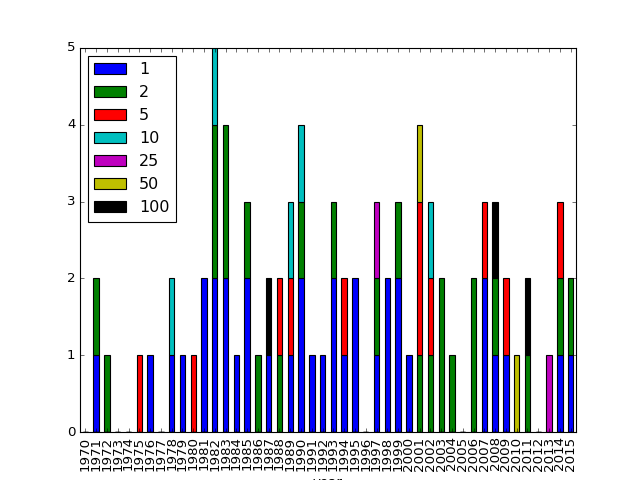

In [18]:
# Plot by number of each n-year storm per year
storms_by_year.plot(kind='bar', stacked=True)

In [19]:
# Let's look at the 1 and 2 year events
small_events = storms_by_year[(storms_by_year[1] > 0) | (storms_by_year[2] > 0)][[1,2]]
small_events['total'] = small_events[1] + small_events[2]
# Add years without events also.
small_events = small_events.reindex(new_indexes, fill_value=0)
small_events.head()

,1,2,total
year,,,
1970,0,0,0
1971,1,1,2
1972,0,1,1
1973,0,0,0
1974,0,0,0


<IPython.core.display.Javascript object>


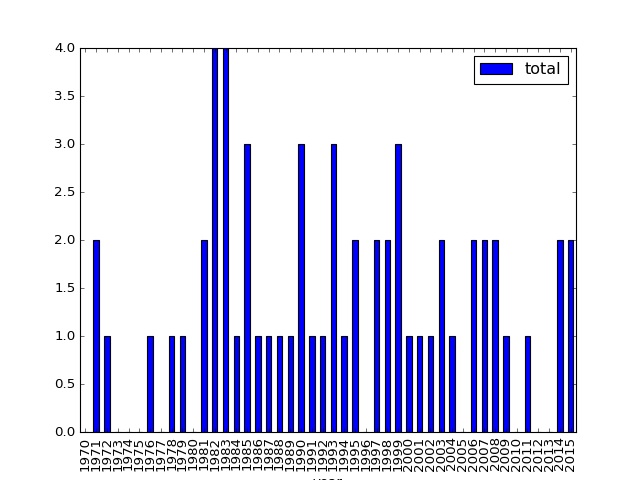

In [20]:
# Number of 1 and 2 year events per year
small_events[['total']].plot(kind='bar')

In [21]:
# They seemingly happened a lot more earlier in the dataset

In [22]:
# Now let's divide the 45 year period into 3 buckets, and compare the number of each storm in these three

In [23]:
# Index the dataframe by year
storms_by_year['year'] = storms_by_year.index

In [24]:
# Now let's divide the 45 year period into 3 buckets, and compare the number of each storm in these three
def find_bucket(year):
    if year < 1985:
        return '1970-1984'
    elif year <= 2000:
        return '1985-2000'
    else:
        return '2001-2015'
storms_by_year['bucket'] = storms_by_year['year'].apply(find_bucket)
storms_by_year = storms_by_year.drop('year', 1)
storms_by_year.tail()

,1,2,5,10,25,50,100,bucket
year,,,,,,,,
2011,0,1,0,0,0,0,1,2001-2015
2012,0,0,0,0,0,0,0,2001-2015
2013,0,0,0,0,1,0,0,2001-2015
2014,1,1,1,0,0,0,0,2001-2015
2015,1,1,0,0,0,0,0,2001-2015


In [25]:
bucketed = storms_by_year.groupby('bucket').sum()
bucketed.head()

,1,2,5,10,25,50,100
bucket,,,,,,,
1970-1984,11,6,2,2,0,0,0
1985-2000,19,7,3,2,1,0,1
2001-2015,6,11,6,1,1,2,2


<IPython.core.display.Javascript object>


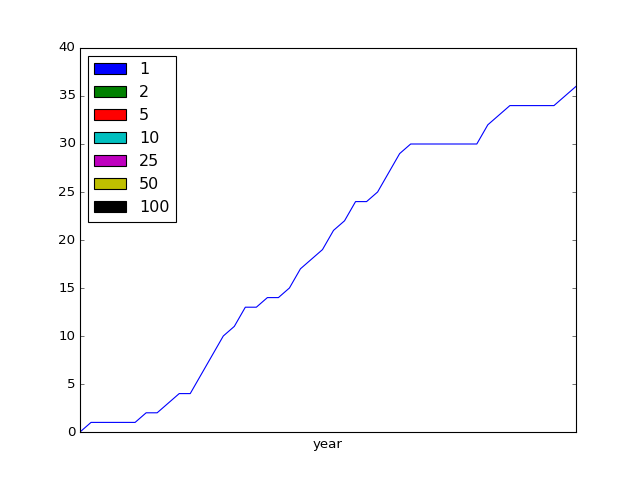

In [26]:
# Plot the number of each storm within each 15 year period.
bucketed.plot(kind='bar', stacked=True)

In [27]:
# It appears that the first part has more of them.  Let's check that out by plotting the cumulative growth of
# 1-year storms over time.
storms_by_year[1].cumsum().plot(kind='line')

In [ ]:
# Let's change the buckets to 5 year spans

In [29]:
storms_by_year.head()

,1,2,5,10,25,50,100,bucket
year,,,,,,,,
1970,0,0,0,0,0,0,0,1970-1984
1971,1,1,0,0,0,0,0,1970-1984
1972,0,1,0,0,0,0,0,1970-1984
1973,0,0,0,0,0,0,0,1970-1984
1974,0,0,0,0,0,0,0,1970-1984


In [42]:
storms_by_year['year'] = storms_by_year.index.values
def find_bucket(year):
    if year < 1976:
        return "1970-1975"
    elif year < 1981:
        return '1976-1980'
    elif year < 1986:
        return '1981-1985'
    elif year < 1991:
        return '1986-1990'
    elif year < 1996:
        return '1991-1995'
    elif year < 2001:
        return '1996-2000'
    elif year < 2006:
        return '2001-2005'
    elif year < 2011:
        return '2006-2010'
    else:
        return '2011-2015'

storms_by_year['bucket'] = storms_by_year['year'].apply(find_bucket)
storms_by_year = storms_by_year.drop('year', 1)
bucketed = storms_by_year.groupby('bucket').sum()
bucketed.head()

,1,2,5,10,25,50,100
bucket,,,,,,,
1970-1975,1,2,1,0,0,0,0
1976-1980,3,0,1,1,0,0,0
1981-1985,9,5,0,1,0,0,0
1986-1990,4,3,2,2,0,0,1
1991-1995,7,1,1,0,0,0,0


<IPython.core.display.Javascript object>


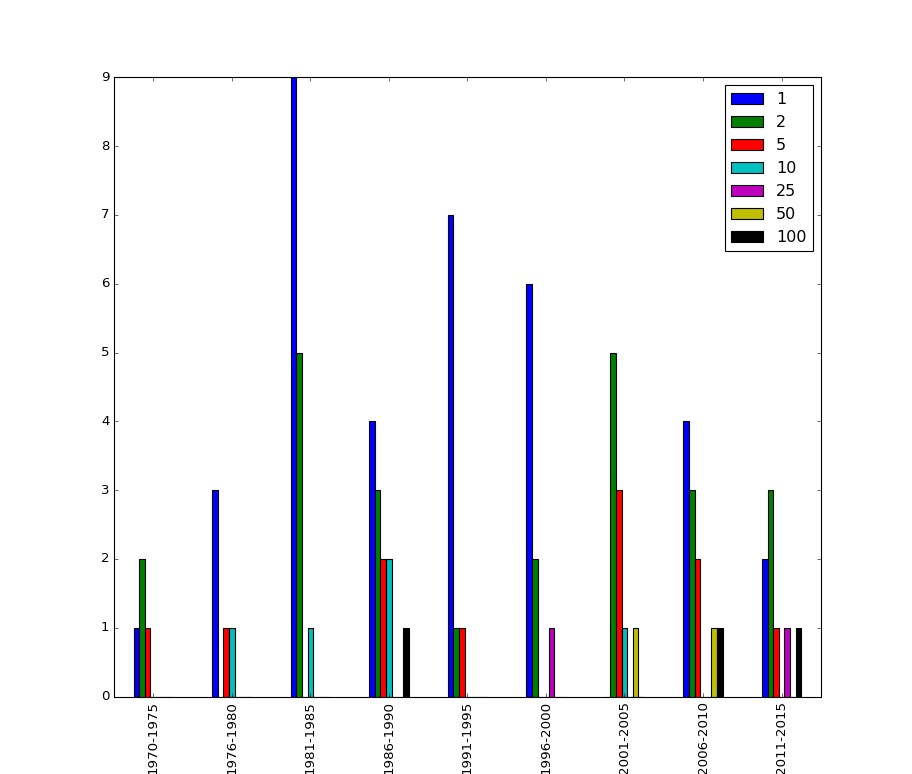

In [44]:
bucketed.plot(kind='bar')